# 准备

## 首先的首先，用哪个数据库训练

In [1]:
GSE_Train = "GSE63990"

## 库 导入

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
import warnings
import GEOparse
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report, accuracy_score, roc_auc_score
warnings.filterwarnings('ignore')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LinearRegression, RidgeClassifier, Ridge, Lasso, LassoCV, LogisticRegression
from sklearn.svm import SVC, LinearSVC, NuSVC

## 数据 导入

In [4]:
GPL571 = GEOparse.get_GEO(geo="GPL571", destdir="./datasets", silent=True)

In [5]:
gse = GEOparse.get_GEO(geo=GSE_Train, destdir="./datasets", silent=True)
gpls = gse.metadata['platform_id']
gpl = GEOparse.get_GEO(geo=gpls[0], destdir="./datasets", silent=True)

In [6]:
gse_csv = pd.read_csv('./datasets/' + GSE_Train + '.csv')
gse_csv.head() # 预览数据

,infection_status,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,...,AFFX-r2-Bs-thr-M_s_at,AFFX-r2-Ec-bioB-3_at,AFFX-r2-Ec-bioB-5_at,AFFX-r2-Ec-bioB-M_at,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at
0,non-infectious illness,107.026284,158.817338,2545.754898,186.244424,13.132469,643.402073,34.615676,17.490946,2929.019555,...,17.173226,422.464901,566.805882,481.918815,1421.477295,1302.020303,6250.362334,3836.600257,17740.725022,14961.589573
1,non-infectious illness,221.020421,124.644738,2143.929143,324.223899,15.427804,1001.622909,49.833883,22.848206,5667.531661,...,17.962223,652.117965,800.852865,822.133404,2305.851262,2008.050881,8731.397156,5399.129367,19067.890695,17285.989865
2,non-infectious illness,137.091142,115.353642,1741.194207,299.526479,13.588461,549.283988,47.869510,18.544460,3186.032084,...,17.282754,483.392556,566.237470,586.430031,1792.943487,1330.467773,7401.441597,4578.962962,18303.281696,15753.041045
3,non-infectious illness,126.175162,98.119250,1316.526914,326.999326,12.738011,339.984798,51.808930,19.624606,5535.493091,...,17.651712,1275.694498,1781.291882,1547.788940,3845.464156,3549.057271,11770.475723,7924.052042,23370.081259,19856.779557
4,bacterial,105.348086,260.359324,2930.300695,223.766173,12.436344,409.723526,35.071703,19.844859,581.984161,...,18.275624,404.702873,518.880900,477.676689,1299.615932,1186.047735,5968.686731,3780.851630,18440.196387,15535.017110


In [7]:
gse_csv.isnull().sum() 

infection_status        0
1007_s_at               0
1053_at                 0
117_at                  0
121_at                  0
                       ..
AFFX-r2-Ec-bioC-5_at    0
AFFX-r2-Ec-bioD-3_at    0
AFFX-r2-Ec-bioD-5_at    0
AFFX-r2-P1-cre-3_at     0
AFFX-r2-P1-cre-5_at     0
Length: 22278, dtype: int64

In [8]:
gse_csv['infection_status'].value_counts() # 看一下感染这个列的分布

viral                     117
non-infectious illness     90
bacterial                  73
Name: infection_status, dtype: int64

## 函数 准备

In [9]:
def plot_score_distribution(ax, y_score, final_target):
    ax.scatter(range(len(y_score)), y_score, c=final_target, cmap='bwr', alpha=0.5)
    ax.set_title('分数分布图')
    ax.set_xlabel('样本序号')
    ax.set_ylabel('分数')
    plt.rcParams['font.sans-serif']=['SimHei'] # 中文乱码
    plt.rcParams['axes.unicode_minus']=False # 负号乱码
    labels = ['细菌感染', '病毒感染']
    ax.legend(labels, loc='upper right')
    ax.plot([0, len(y_score)], [0.5, 0.5], color='black', lw=1, linestyle='--')

def plot_roc_curve(ax, y_score, final_target):
    fpr, tpr, thresholds = roc_curve(final_target, y_score)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlabel('False Positive Rate 假阳性率')
    ax.set_ylabel('True Positive Rate 真阳性率')
    ax.set_title('ROC 曲线（受试者工作特征曲线）')
    ax.legend(loc="lower right")

def plot_pr_curve(ax, y_score, final_target):
    precision, recall, thresholds = precision_recall_curve(final_target, y_score)
    ax.plot(recall, precision, color='darkorange', lw=2, label='PR curve')
    ax.set_xlabel('Recall 召回率')
    ax.set_ylabel('Precision 准确率')
    ax.set_title('PR 曲线（准确率-召回率曲线）')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(loc="lower left")

def plot_confusion_matrix(ax, y_score, final_target):
    y_pred = np.where(y_score > 0.5, 1, 0)
    cnf_matrix = confusion_matrix(final_target, y_pred)
    ax.imshow(cnf_matrix, interpolation='nearest')
    ax.set_title('Confusion Matrix 混淆矩阵')
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['病毒感染', '细菌感染'], rotation=45)
    plt.yticks(tick_marks, ['病毒感染', '细菌感染'])
    thresh = cnf_matrix.max() / 2.
    for i in range(cnf_matrix.shape[0]):
        for j in range(cnf_matrix.shape[1]):
            plt.text(j, i, cnf_matrix[i, j],horizontalalignment="center",color="white" if cnf_matrix[i, j] > thresh else "black",fontsize=20)
    plt.tight_layout()
    plt.ylabel('True label 感染情况')
    plt.xlabel('Predicted label 预测情况')

def plot_all(score, target, title="分数分布图、ROC曲线、PR曲线和混淆矩阵", feature=None, weight=None):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    fig.suptitle(title, fontsize=16)
    plot_score_distribution(axs[0,0], score, target)
    plot_roc_curve(axs[0,1], score, target)
    plot_pr_curve(axs[1,0], score, target)
    plot_confusion_matrix(axs[1,1], score, target)
    if feature or weight:
        try:
            # add margin at bottom
            fig.subplots_adjust(bottom=0.12)
            # add feature and weight at the bottom
            fig.text(0.5, 0.04, '使用feature:'+str(feature), ha='center', va='bottom', fontsize=12)
            fig.text(0.5, 0.02, '对应权重:'+str(weight), ha='center', va='bottom', fontsize=8)
        except:
            pass
    return fig, axs

def testfeature(feature,weight,data,gpl=gpl,title="分数分布图、ROC曲线、PR曲线和混淆矩阵"):
    ID = []
    for i in range(len(feature)):
        ID.append(gpl.table[gpl.table['Gene Symbol'] == feature[i]]['ID'].values[0])
    ID = np.array(ID).reshape(-1)
    testdata = data[ID]
    n = len(testdata)
    y_score = np.zeros(n)
    y_pred = np.zeros(n)
    for i in range(len(testdata)):
        y_score [i] = np.dot(testdata.iloc[i],weight)
        y_pred [i] = np.where(y_score[i] > 0.5, 1, 0)
    try:
        target = data['infection_status'].values
    except:
        target = gse_csv['infection_status']
    acc = accuracy_score(target, y_pred)
    print("Accuracy: ", acc)
    fig, axs = plot_all(y_score, target, title, feature=feature, weight=weight)

def testfeaturewithtimes(feature,weight,data,times=1,gpl=gpl,title="分数分布图、ROC曲线、PR曲线和混淆矩阵"):
    ID = []
    for i in range(len(feature)):
        ID.append(gpl.table[gpl.table['Gene Symbol'] == feature[i]]['ID'].values[0])
    ID = np.array(ID).reshape(-1)
    testdata = data[ID]
    n = len(testdata)
    y_score = np.zeros(n)
    y_pred = np.zeros(n)
    for i in range(len(testdata)):
        y_score [i] = np.dot(testdata.iloc[i],weight)
        # 结果除以times
        y_score [i] = y_score [i] / times
        y_pred [i] = np.where(y_score[i] > 0.5, 1, 0)
    try:
        target = data['infection_status'].values
    except:
        target = gse_csv['infection_status']
    acc = accuracy_score(target, y_pred)
    print("Accuracy: ", acc)
    fig, axs = plot_all(y_score, target, title, feature=feature, weight=weight)

def testfeaturewithtimesandtarget(feature,weight,data,target,times=1,gpl=gpl,title="分数分布图、ROC曲线、PR曲线和混淆矩阵"):
    ID = []
    for i in range(len(feature)):
        ID.append(gpl.table[gpl.table['Gene Symbol'] == feature[i]]['ID'].values[0])
    ID = np.array(ID).reshape(-1)
    testdata = data[ID]
    n = len(testdata)
    y_score = np.zeros(n)
    y_pred = np.zeros(n)
    for i in range(len(testdata)):
        y_score [i] = np.dot(testdata.iloc[i],weight)
        # 结果除以times
        y_score [i] = y_score [i] / times
        y_pred [i] = np.where(y_score[i] > 0.5, 1, 0)
    acc = accuracy_score(target, y_pred)
    print("Accuracy: ", acc)
    fig, axs = plot_all(y_score, target, title, feature=feature, weight=weight)


In [10]:
def find_best_n(ax,X_train, y_train, X_test, y_test, method, model, max_features=20):
    train_acc,test_acc,train_roc,test_roc = [],[],[],[]
    for i in range(1, max_features):
        # reselect the features
        reselect = SelectKBest(score_func=method, k=i)
        reselect.fit(X_train, y_train)
        model.fit(X_train.iloc[:, reselect.get_support(indices=True)], y_train) # use the selected features to train the data
        y_pred = model.predict(X_test.iloc[:, reselect.get_support(indices=True)])
        train_acc.append(model.score(X_train.iloc[:, reselect.get_support(indices=True)], y_train))
        test_acc.append(model.score(X_test.iloc[:, reselect.get_support(indices=True)], y_test))
        train_roc.append(roc_auc_score(y_train, model.predict(X_train.iloc[:, reselect.get_support(indices=True)])))
        test_roc.append(roc_auc_score(y_test, model.predict(X_test.iloc[:, reselect.get_support(indices=True)])))
    # ax.plot(range(1, max_features), train_acc, label='train_acc')
    ax.plot(range(1, max_features), test_acc, label='test_acc')
    # ax.plot(range(1, max_features), train_roc, label='train_roc')
    ax.plot(range(1, max_features), test_roc, label='test_roc')
    ax.set_title('使用'+str(model) + '和' + method.__name__ + '选择特征')
    plt.rcParams['font.sans-serif'] = ['SimHei']
    ax.legend()
    # grid
    ax.grid()
    # mark the maximum value
    ax.scatter(test_acc.index(max(test_acc)) + 1, max(test_acc), marker='o', color='b')
    ax.text(test_acc.index(max(test_acc)) + 1, max(test_acc), str(test_acc.index(max(test_acc)) + 1) + ', ' + str('%.2f%%' % (max(test_acc) * 100)))
    ax.scatter(test_roc.index(max(test_roc)) + 1, max(test_roc), marker='o', color='r')
    ax.text(test_roc.index(max(test_roc)) + 1, max(test_roc), str(test_roc.index(max(test_roc)) + 1) + ', ' + str('%.2f%%' % (max(test_roc) * 100)))
    # y is 0.5 to 1
    ax.set_ylim(0.5, 1)

    select = SelectKBest(score_func=method, k=test_acc.index(max(test_acc)) + 1).fit(X_train, y_train)
    X_train_new = select.transform(X_train)
    X_test_new = select.transform(X_test)
    model.fit(X_train_new, y_train)
    y_pred = model.predict(X_test_new)
    # print('使用' + str(model) + '和' + method.__name__ + '选择特征后的准确率为：', model.score(X_test_new, y_test))
    # print('使用' + str(model) + '和' + method.__name__ + '选择特征后的AUC为：', roc_auc_score(y_test, y_pred))
    # # print('使用' + str(model) + '和' + method.__name__ + '选择特征后的权重为：', model.coef_)
    # print('使用' + str(model) + '和' + method.__name__ + '选择特征后的截距为：', model.intercept_)
    # get column names
    gene_id = X_train.columns[select.get_support(indices=True)]
    gene_symbol = [gpl.table[gpl.table['ID'] == i]['Gene Symbol'].values[0] for i in gene_id]
    # print('使用' + str(model) + '和' + method.__name__ + '选择特征后的特征为：', gene_symbol)
    # print('使用' + str(model) + '和' + method.__name__ + '选择特征后的特征权重为：', model.coef_)
    
    n = test_acc.index(max(test_acc)) + 1
    best_acc = max(test_acc)

    return best_acc, n, gene_symbol, model.coef_


In [91]:
def find_best_n(ax,X_train, y_train, X_test, y_test, method, model, max_features=20):
    train_acc,test_acc,train_roc,test_roc = [],[],[],[]
    for i in range(1, max_features):
        if method == 'mannual':
            reselect = X_train.iloc[:, :i]
            model.fit(reselect, y_train) # use the selected features to train the data
            y_pred = model.predict(X_test.iloc[:, :i])
            train_acc.append(model.score(reselect, y_train))
            test_acc.append(model.score(X_test.iloc[:, :i], y_test))
            train_roc.append(roc_auc_score(y_train, model.predict(reselect)))
            test_roc.append(roc_auc_score(y_test, model.predict(X_test.iloc[:, :i])))
        else:
            reselect = SelectKBest(score_func=method, k=i)
            reselect.fit(X_train, y_train)
            model.fit(X_train.iloc[:, reselect.get_support(indices=True)], y_train) # use the selected features to train the data
            y_pred = model.predict(X_test.iloc[:, reselect.get_support(indices=True)])
            train_acc.append(model.score(X_train.iloc[:, reselect.get_support(indices=True)], y_train))
            test_acc.append(model.score(X_test.iloc[:, reselect.get_support(indices=True)], y_test))
            train_roc.append(roc_auc_score(y_train, model.predict(X_train.iloc[:, reselect.get_support(indices=True)])))
            test_roc.append(roc_auc_score(y_test, model.predict(X_test.iloc[:, reselect.get_support(indices=True)])))
    # ax.plot(range(1, max_features), train_acc, label='train_acc')
    ax.plot(range(1, max_features), test_acc, label='test_acc')
    # ax.plot(range(1, max_features), train_roc, label='train_roc')
    ax.plot(range(1, max_features), test_roc, label='test_roc')
    if method == 'mannual':
        ax.set_title('使用'+str(model) + '按照表达比选择特征')
    else:
        ax.set_title('使用'+str(model) + '和' + method.__name__ + '选择特征')
    plt.rcParams['font.sans-serif'] = ['SimHei']
    ax.legend()
    # grid
    ax.grid()
    # mark the maximum value
    ax.scatter(test_acc.index(max(test_acc)) + 1, max(test_acc), marker='o', color='b')
    ax.text(test_acc.index(max(test_acc)) + 1, max(test_acc), str(test_acc.index(max(test_acc)) + 1) + ', ' + str('%.2f%%' % (max(test_acc) * 100)))
    ax.scatter(test_roc.index(max(test_roc)) + 1, max(test_roc), marker='o', color='r')
    ax.text(test_roc.index(max(test_roc)) + 1, max(test_roc), str(test_roc.index(max(test_roc)) + 1) + ', ' + str('%.2f%%' % (max(test_roc) * 100)))
    # y is 0.5 to 1
    ax.set_ylim(0.5, 1)

    if method != 'mannual':
        select = SelectKBest(score_func=method, k=test_acc.index(max(test_acc)) + 1).fit(X_train, y_train)
        X_train_new = select.transform(X_train)
        X_test_new = select.transform(X_test)
        model.fit(X_train_new, y_train)
        y_pred = model.predict(X_test_new)
        gene_id = X_train.columns[select.get_support(indices=True)]
    else:
        X_train_new = X_train.iloc[:, :test_acc.index(max(test_acc)) + 1]
        X_test_new = X_test.iloc[:, :test_acc.index(max(test_acc)) + 1]
        model.fit(X_train_new, y_train)
        y_pred = model.predict(X_test_new)
        gene_id = X_train_new.columns
    gene_symbol = [gpl.table[gpl.table['ID'] == i]['Gene Symbol'].values[0] for i in gene_id]
    # print('使用' + str(model) + '和' + method.__name__ + '选择特征后的特征为：', gene_symbol)
    # print('使用' + str(model) + '和' + method.__name__ + '选择特征后的特征权重为：', model.coef_)
    
    n = test_acc.index(max(test_acc)) + 1
    best_acc = max(test_acc)

    return best_acc, n, gene_symbol, model.coef_


In [11]:
def predict(model, X, time=None):
    # if not coef: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
    if time is not None:
        coef = model.coef_.ravel() * time
        coef = np.round(coef)
        time = float(time)
    else:
        time = 1
        time = float(time)
        coef = model.coef_.ravel()
    if model.__class__.__name__ == 'LinearRegression':
        y_pred = float(np.dot(X, coef))/time + model.intercept_ 
    elif model.__class__.__name__ == 'RidgeClassifier':
        y_pred = np.dot(X, coef)/time + model.intercept_ + 0.5# 以0为分界（？
    elif model.__class__.__name__ == 'LogisticRegression':
        z = np.dot(X, coef)/time + model.intercept_
        y_pred = 1 / (1 + np.exp(-z))
        # y_pred = np.dot(X, model.coef_.ravel()) + model.intercept_
    elif model.__class__.__name__ == 'LinearSVC':
        y_pred = np.dot(X, coef)/time + model.intercept_
    elif model.__class__.__name__ == 'NuSVC':
        y_pred = np.dot(X, coef) / time + model.intercept_ + 0.5 # 以0为分界（？
    else:
        y_pred = model.predict(X)
    return y_pred

In [148]:
def test_method(select_method, model, n_feature, X_train, X_test, y_train, y_test):
    reselect = SelectKBest(score_func=select_method, k=n_feature)
    reselect.fit(X_train, y_train)
    X_train_new = reselect.transform(X_train)
    print(X_train_new.shape)
    X_test_new = reselect.transform(X_test)
    print(X_test_new.shape)
    model.fit(X_train_new, y_train)
    y_score= predict(model, X_test_new)
    y_pred = model.predict(X_test_new)
    model_acc = np.mean(np.equal(y_pred, y_test))
    print('使用' + str(model) + '和' + select_method.__name__ + '选择特征后的准确率为：', model_acc)
    title = '使用' + select_method.__class__.__name__ + '选择' + str(n_feature) + '个特征的' + model.__class__.__name__ + '的直接运算的预测结果'
    gene_id = X_train.columns[reselect.get_support(indices=True)]
    feature = [gpl.table[gpl.table['ID'] == i]['Gene Symbol'].values[0] for i in gene_id]
    plot_all(
        score = y_score,
        target = y_test,
        title = title,
        feature = feature,
        weight = model.coef_.ravel())
    plt.show()
    coef = model.coef_

    times = np.logspace(1, 8, num=500, base=10)
    accs = []
    match = 0
    for time in times:
        y_score = predict(model, X_test_new, time)
        y_pred = np.array([1 if i > 0.5 else 0 for i in y_score], dtype=int)
        accs.append(np.mean(y_pred == y_test))
        if np.mean(y_pred == y_test) == model_acc:
            match += 1
            if match == 5:
                print('time =', time, 'acc =', np.mean(y_pred == y_test))
                print('coef =', np.round(model.coef_.ravel() * time))
                print('intercept =', model.intercept_)
                match = 0
        else:
            match = 0
    plt.plot(times, accs)
    plt.xlabel('times')
    plt.ylabel('accuracy')
    plt.title('Relationship between times and accuracy')
    plt.xscale('log')
    plt.show()

    coef = model.coef_

    return coef, reselect

In [14]:
def plot_boxplot(data_higher, gpl, gse_csv, data_higher_times):
    fig, ax = plt.subplots(1,50, figsize=(50,15))
    for i in range(50):
        sns.boxplot(
            x='infection_status', 
            y=data_higher.iloc[:,i],
            data=gse_csv,
            ax=ax[i],
            )
        ax[i].set_title(gpl.table[gpl.table['ID'] == data_higher.columns[i]]['Gene Symbol'].values[0])

        # 最上面加上对应的倍数
        ax[i].text(0.1, 0.98,
                   str('%.2f' % data_higher_times[i]),
                   transform=ax[i].transAxes,
                   fontsize=16,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

        # 显示优化
        ax[i].set_yscale('log') #对数坐标
        ax[i].set_ylim(10, 40000) # y轴的范围
        if i != 0: # 不显示x，y轴的标签， 不然太挤了没意义
            ax[i].set_xlabel('')
            ax[i].set_yticklabels([])
            ax[i].set_ylabel('')
            ax[i].set_yticks([])
        else:
            ax[i].set_xlabel('')
            ax[i].set_ylabel('表达量')
        ax[i].tick_params(axis='x', rotation=90) # 不然画不下
    plt.show()

In [15]:
def get_higher_columns(data):
    data_mean = data.groupby('target').mean()
    higher_columns = []
    higher_times = []
    for i in range(data_mean.shape[1]):
        if data_mean.iloc[1,i] > 2*data_mean.iloc[0,i]:
            higher_columns.append(data_mean.columns[i])
            higher_times.append(data_mean.iloc[1,i]/data_mean.iloc[0,i])
    return higher_columns, higher_times

In [25]:
def sort_higher_columns(data, higher_columns, higher_times):
    # sort the columns and times together
    data_higher_times, data_higher_columns = zip(*sorted(zip(higher_times, higher_columns), reverse=True))
    # convert data_higher_columns to list
    data_higher_columns = list(data_higher_columns)
    # add target column to the top of data_higher_columns
    data_higher_columns.append('target')
    data_higher_columns.append('infection_status')
    # get the new data
    data_higher = data[data_higher_columns]
    return data_higher, data_higher_times

# 训练

## 病毒

### 分开病毒与未感染

In [16]:
# 病毒与未感染的鉴别
viral_data = gse_csv[gse_csv['infection_status'].isin(['viral', 'non-infectious illness', 'bacterial'])]
viral_data['target'] = viral_data['infection_status'].map({'viral': 1, 'non-infectious illness': 0, 'bacterial': 0})
X_train, X_test, y_train, y_test = train_test_split(viral_data.drop(['infection_status'], axis=1), viral_data['infection_status'], test_size=0.2, random_state=0)

### 筛选出 病毒感染中表达量大于等于2倍的非病毒感染表达量的基因

In [17]:
higher_columns, higher_times = get_higher_columns(viral_data)

根据倍率不同进行排序

In [29]:
data_higher, data_higher_times = sort_higher_columns(viral_data, higher_columns, higher_times)
X_train, X_test, y_train, y_test = train_test_split(data_higher.drop(['infection_status','target'], axis=1), data_higher['target'], test_size=0.2, random_state=0)

使用 boxplot 对排序后的基因画图，选了前50个

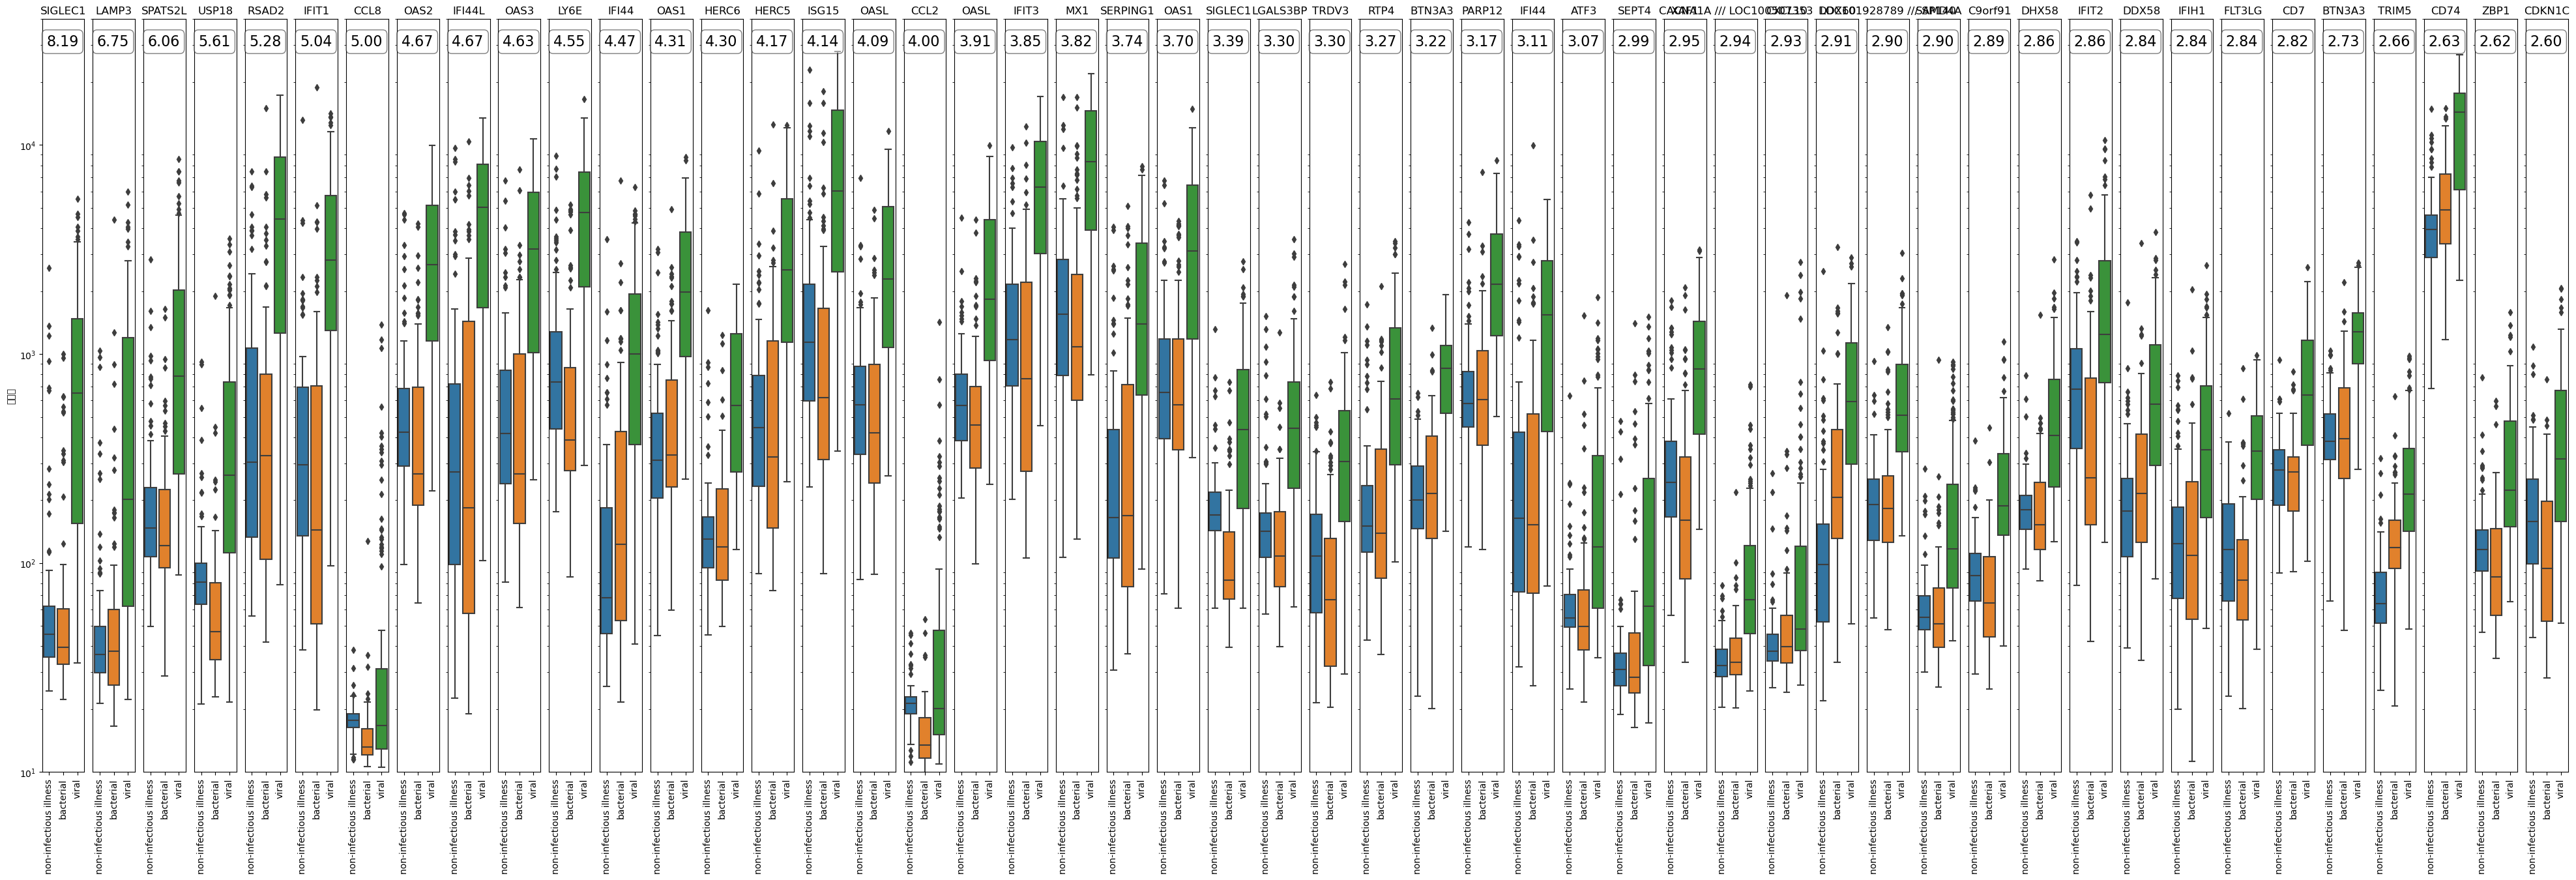

In [28]:
plot_boxplot(data_higher, gpl, gse_csv, data_higher_times)

### 训练不同的模型，使用不同的特征选择方法，选择出特征后，使用不同的方法来训练模型

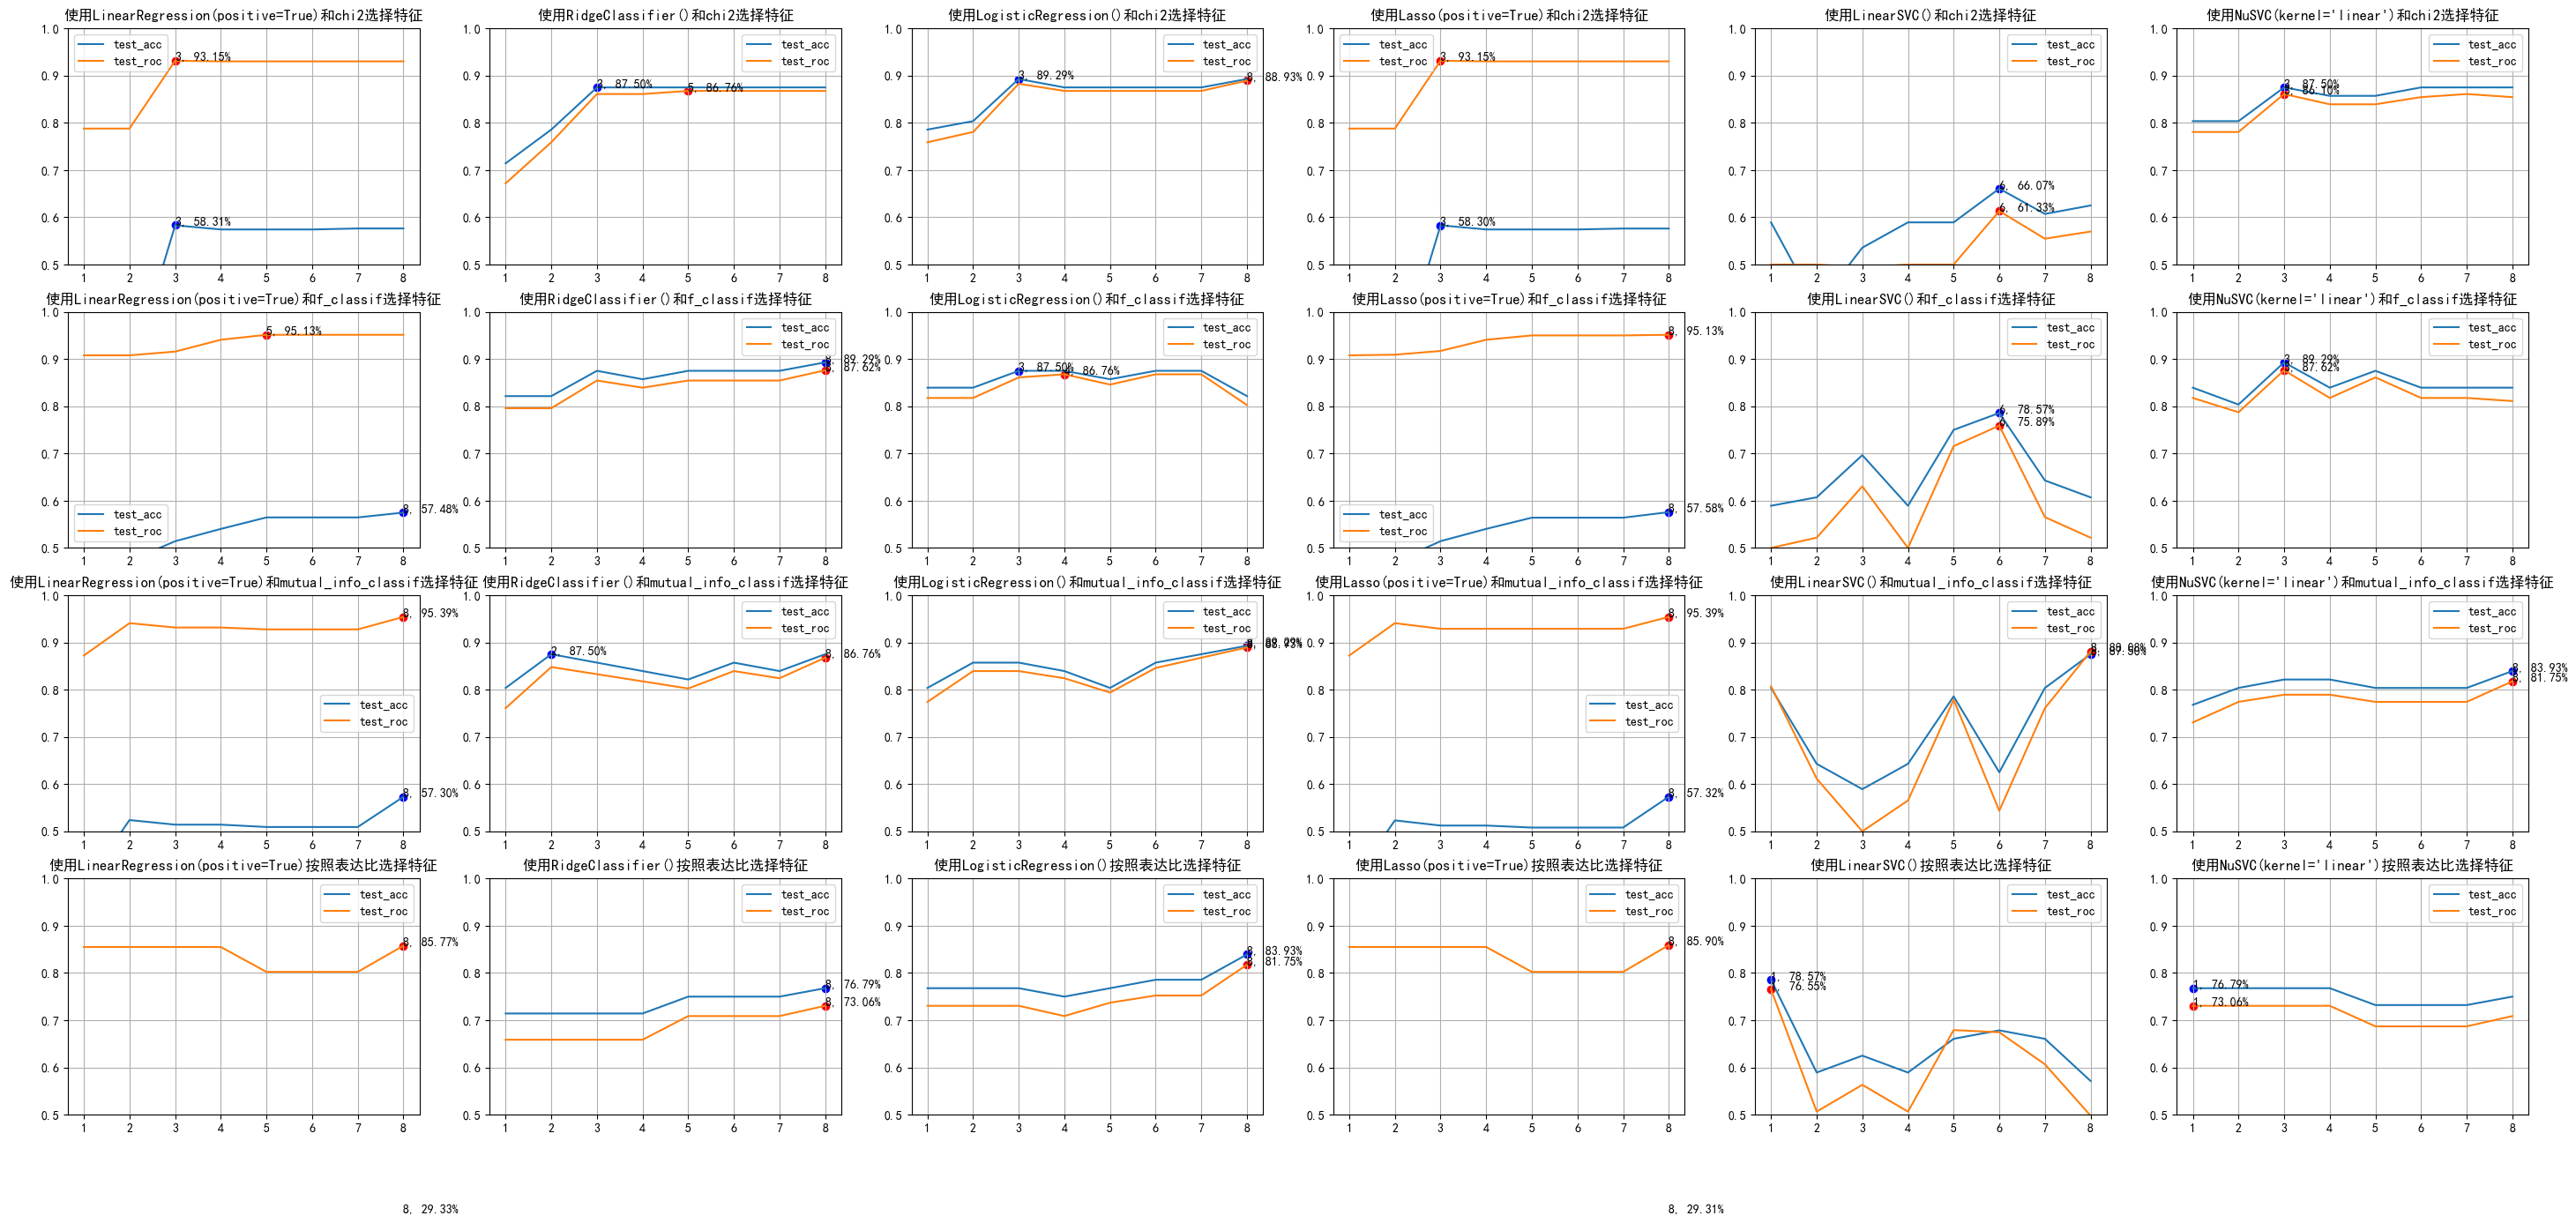

In [92]:
methods = [chi2, f_classif, mutual_info_classif,'mannual']
models = [
    # https://scikit-learn.org/stable/modules/linear_model.html
    LinearRegression(
        positive=True
    ),                              # 普通 的 非负
    RidgeClassifier(
    ),                              # 是最小二乘法的正则化版本，明显快于例如 LogisticRegression，该分类器有时称为具有线性内核的最小二乘支持向量机
    LogisticRegression(
    ),                              # 逻辑回归
    Lasso(
        positive=True
    ),                              # 稀疏的 非负
    # SVC(
    #     kernel='linear',
    #     class_weight='balanced'
    # ),                            # 超级超级超级慢 一次5~6分钟
    LinearSVC(
        
    ),
    NuSVC(
        kernel='linear'
    )
]
# methods = [chi2]
# models = [LinearRegression()]
fig, axs = plt.subplots(len(methods), len(models), figsize=(6*len(models), 4*len(methods)))
test_accs = []
best_n = []
rocs = []
gene_symbols = []
coefs = []
for method in methods:
    for model in models:
        # find_best_n(axs[methods.index(method), models.index(model)], X_train, y_train, X_test, y_test, method, model, max_features=6)
        test_acc, n, gene_symbol, coef = find_best_n(
            axs[methods.index(method), models.index(model)], 
            X_train, y_train, X_test, y_test, 
            method, 
            model, 
            max_features=9)
        test_accs.append(test_acc)
        best_n.append(n)
        gene_symbols.append(gene_symbol)
        coefs.append(coef)
plt.show()

获取上面训练的结果 —— 筛选出上面的表中表现的较好的方法

In [93]:
def print_best_acc(test_acc, n, gene_symbol, coef):
    best_acc = max(test_acc)
    best_i = 0
    i = 0
    print('最好的准确率为：', best_acc)
    for acc in test_acc:
        if acc == best_acc:
            print('='*60)
            print('对应的特征数为：', n[i],'方法为：', methods[i // len(models)].__name__,'特征为：', gene_symbol[i])
            print('模型为：', models[i % len(models)],'特征权重为：', coef[i])
            weights_avg = np.mean(coef[i])
            new_coefs = []
            for j in range(len(coef[i])):
                # new_coefs.append(10*(coef[i][j]/weights_avg)) 保留2位小数
                # new_coefs.append(round(10*(coef[i][j]/weights_avg), 2)) type numpy.ndarray doesn't define __round__ method
                new_coefs.append(np.round(10*(coef[i][j]/weights_avg), 2))
            print('比例大致为：', new_coefs)
        i += 1

In [94]:
print_best_acc(test_accs, best_n, gene_symbols, coefs)

最好的准确率为： 0.8928571428571429
对应的特征数为： 3 方法为： chi2 特征为： ['ISG15', 'MX1', 'CD74']
模型为： LogisticRegression() 特征权重为： [[1.34432285e-04 9.88563167e-05 2.84598682e-04]]
比例大致为： [array([ 7.79,  5.73, 16.49])]
对应的特征数为： 8 方法为： f_classif 特征为： ['BTN3A3', 'BTN3A3', 'CD74', 'EVL', 'BTN3A2', 'HLA-DPA1', 'OGFOD1', 'PLEKHO1']
模型为： RidgeClassifier() 特征权重为： [[ 9.23593146e-04 -2.41337391e-04 -9.80730294e-06  1.92594588e-04
   1.86564367e-04  4.38219787e-05 -4.89474105e-04  2.89877598e-04]]
比例大致为： [array([ 82.48, -21.55,  -0.88,  17.2 ,  16.66,   3.91, -43.71,  25.89])]
对应的特征数为： 3 方法为： f_classif 特征为： ['BTN3A3', 'BTN3A3', 'BTN3A2']
模型为： NuSVC(kernel='linear') 特征权重为： [[0.00043695 0.00054923 0.00063612]]
比例大致为： [array([ 8.08, 10.16, 11.76])]
对应的特征数为： 8 方法为： mutual_info_classif 特征为： ['SIGLEC1', 'LAMP3', 'LY6E', 'BTN3A3', 'LOC101928789 /// SP140', 'EVL', 'C19orf66', 'MIR7703 /// PSME2']
模型为： LogisticRegression() 特征权重为： [[ 0.0005222  -0.00020527  0.00018486  0.0035323  -0.00343703  0.00063779
   0.0022063   0.0003

(224, 3)
(56, 3)
使用LogisticRegression()和chi2选择特征后的准确率为： 0.9107142857142857


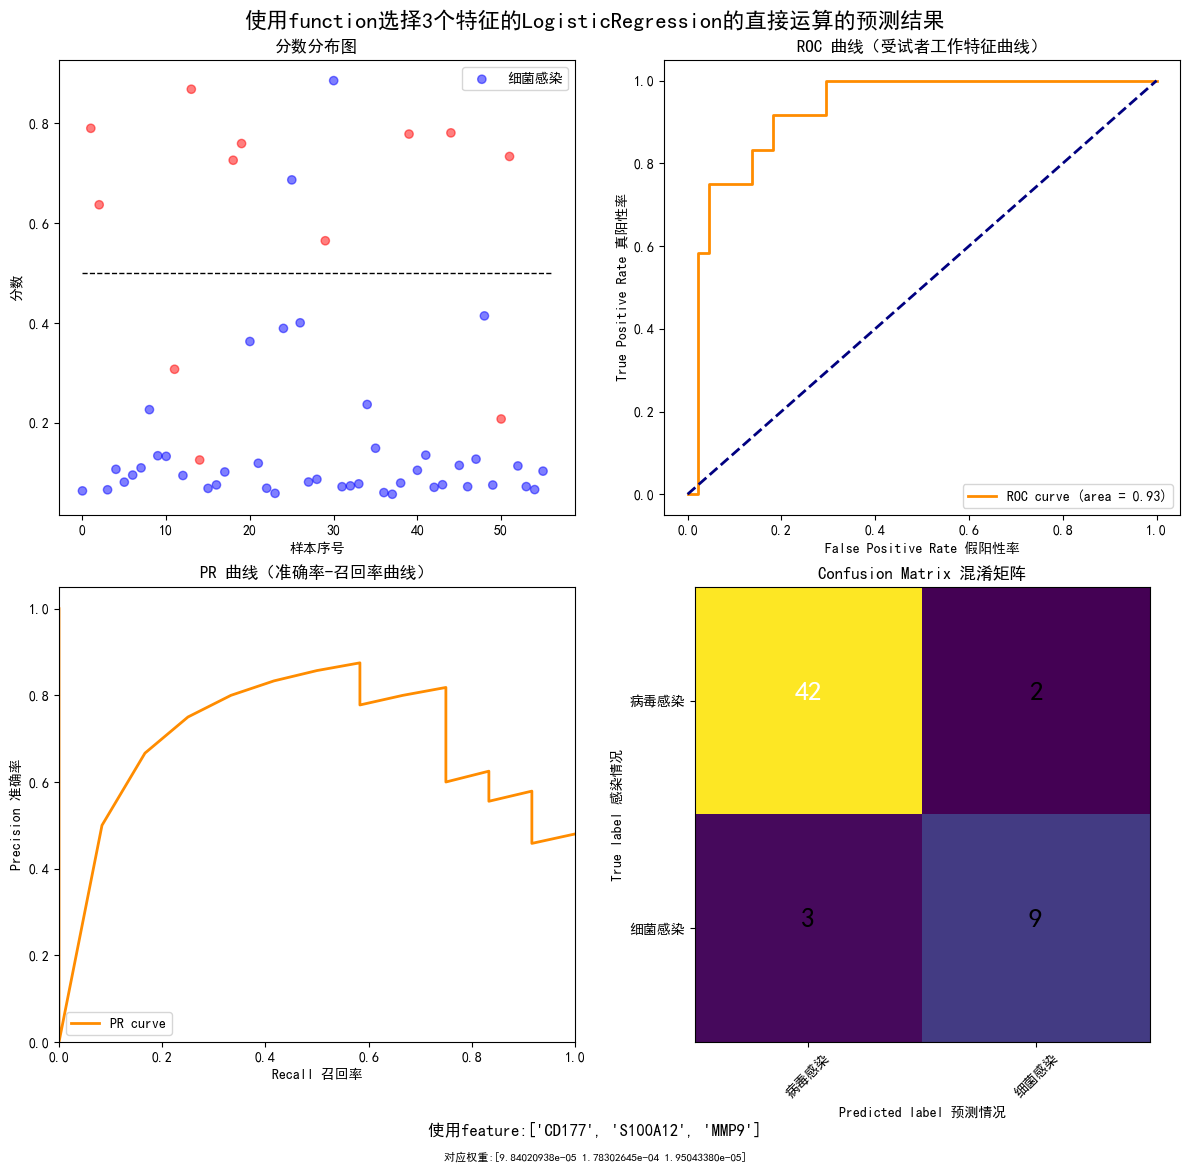

time = 10046.250617173402 acc = 0.9107142857142857
coef = [1. 2. 0.]
intercept = [-2.8716859]
time = 36570.10880777493 acc = 0.9107142857142857
coef = [4. 7. 1.]
intercept = [-2.8716859]
time = 42980.01206490798 acc = 0.9107142857142857
coef = [4. 8. 1.]
intercept = [-2.8716859]
time = 50513.424688167666 acc = 0.9107142857142857
coef = [5. 9. 1.]
intercept = [-2.8716859]
time = 59367.27216069126 acc = 0.9107142857142857
coef = [ 6. 11.  1.]
intercept = [-2.8716859]
time = 69772.99649665538 acc = 0.9107142857142857
coef = [ 7. 12.  1.]
intercept = [-2.8716859]
time = 82002.6061993413 acc = 0.9107142857142857
coef = [ 8. 15.  2.]
intercept = [-2.8716859]
time = 96375.7866384109 acc = 0.9107142857142857
coef = [ 9. 17.  2.]
intercept = [-2.8716859]
time = 113268.25671361538 acc = 0.9107142857142857
coef = [11. 20.  2.]
intercept = [-2.8716859]
time = 133121.59025043077 acc = 0.9107142857142857
coef = [13. 24.  3.]
intercept = [-2.8716859]
time = 156454.7588616096 acc = 0.9107142857142857


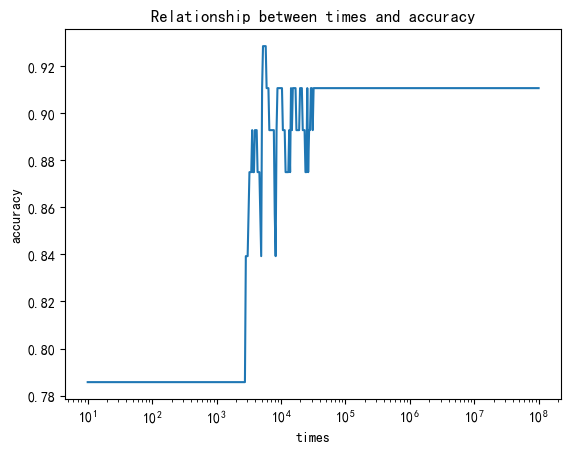

In [149]:
coef, reselect = test_method(
    chi2, 
    LogisticRegression(),
    3, 
    X_train, X_test, y_train, y_test)

## 细菌

In [105]:
# 病毒与未感染的鉴别
bacterial_data = gse_csv[gse_csv['infection_status'].isin(['viral', 'non-infectious illness', 'bacterial'])]
bacterial_data['target'] = bacterial_data['infection_status'].map({'bacterial': 1, 'non-infectious illness': 0, 'viral': 0})
X_train, X_test, y_train, y_test = train_test_split(bacterial_data.drop(['infection_status'], axis=1), bacterial_data['infection_status'], test_size=0.2, random_state=0)
bacterial_data['infection_status'].value_counts()

viral                     117
non-infectious illness     90
bacterial                  73
Name: infection_status, dtype: int64

In [107]:
higher_columns, higher_times = get_higher_columns(bacterial_data)

In [115]:
data_higher, data_higher_times = sort_higher_columns(bacterial_data, higher_columns, higher_times)
X_train, X_test, y_train, y_test = train_test_split(data_higher.drop(['infection_status','target'], axis=1), data_higher['target'], test_size=0.2, random_state=0)

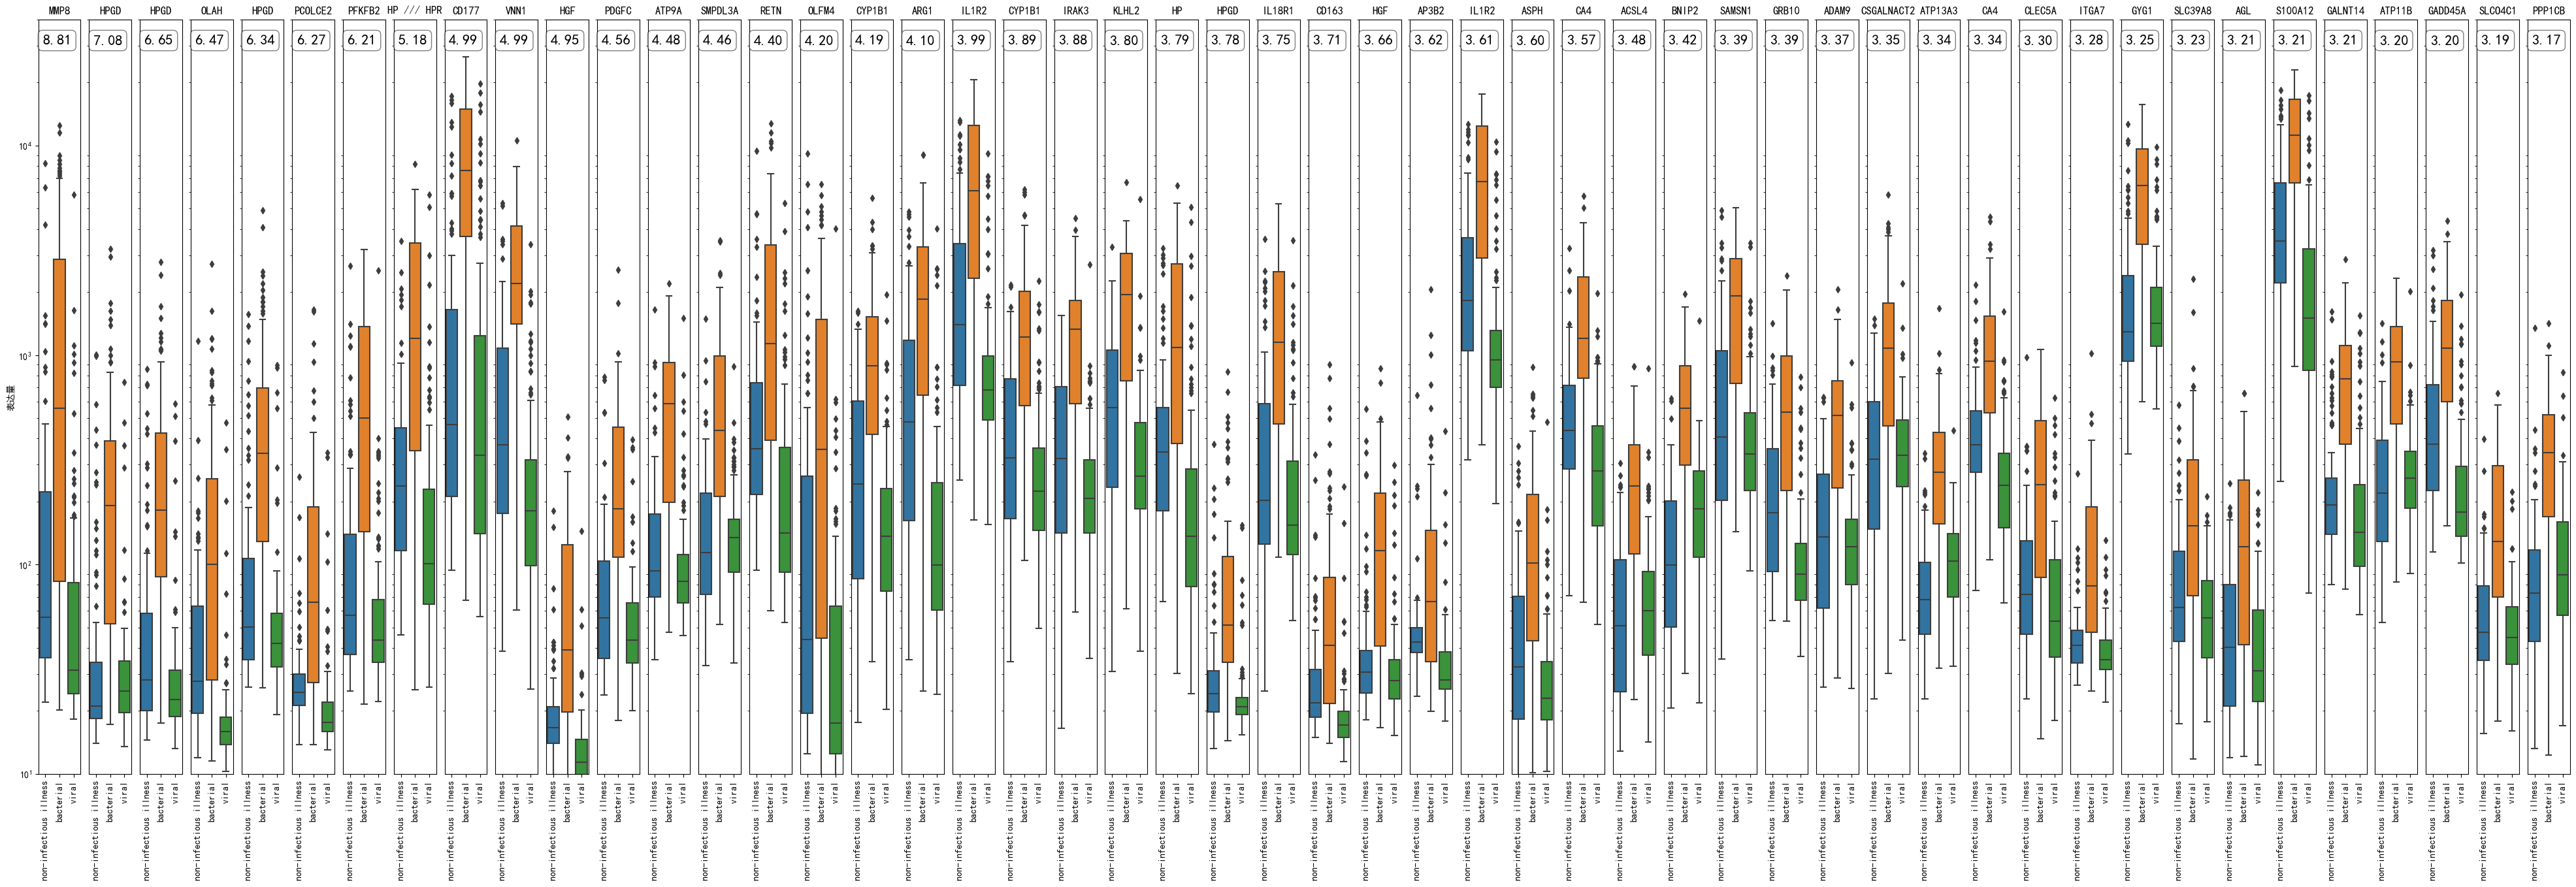

In [114]:
plot_boxplot(data_higher, gpl, gse_csv, data_higher_times)

选

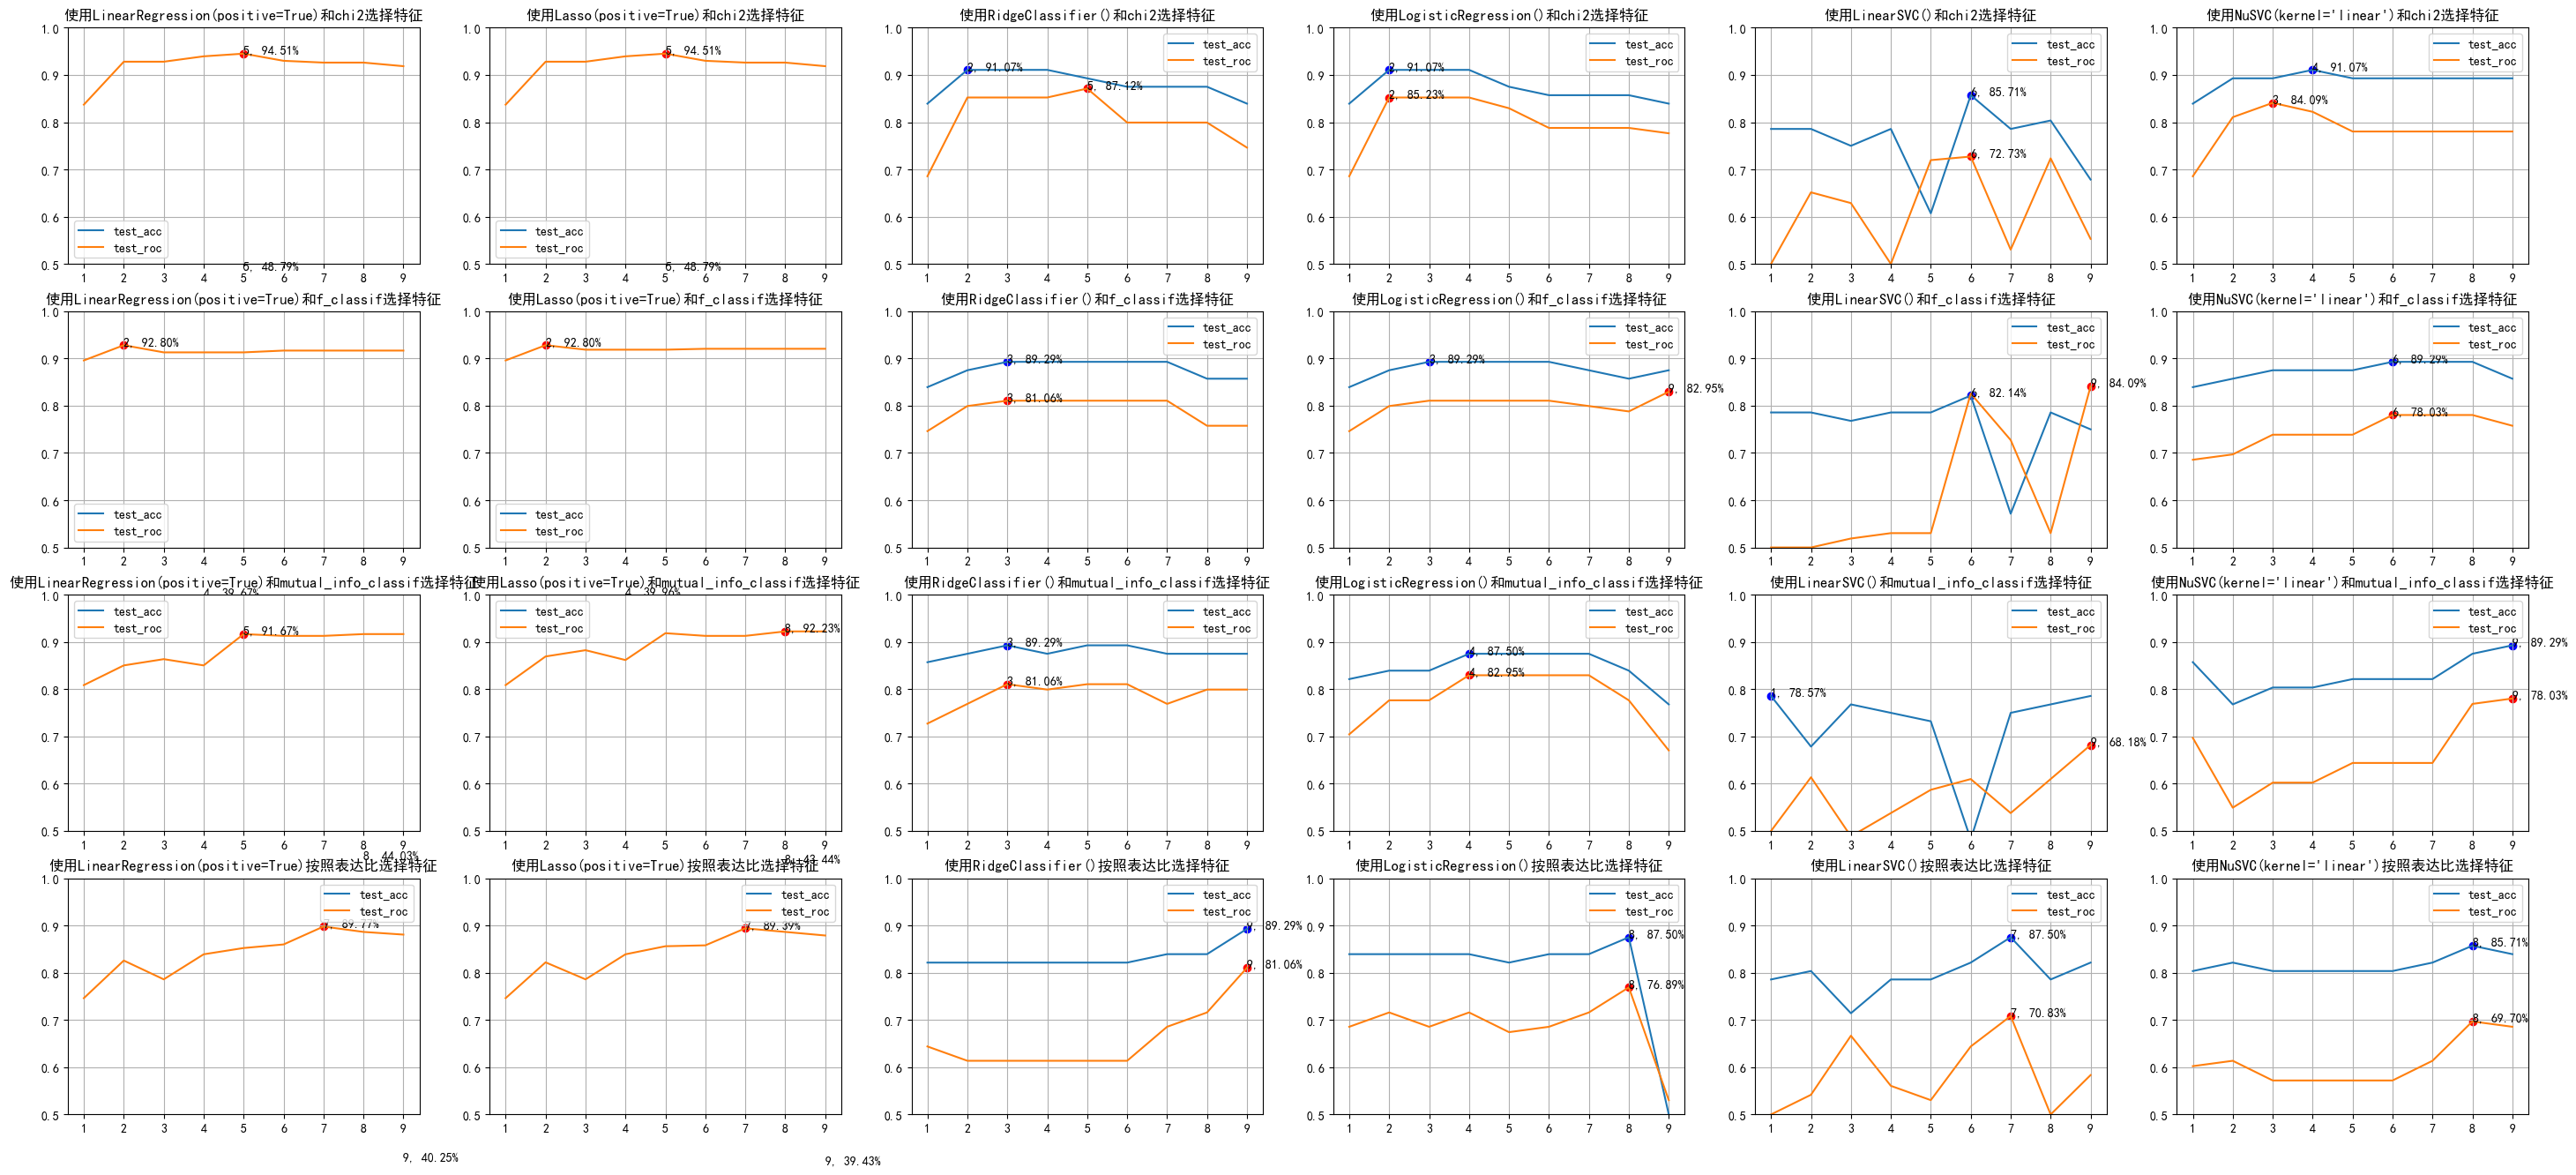

In [116]:
methods = [chi2, f_classif, mutual_info_classif,'mannual']
models = [
    # https://scikit-learn.org/stable/modules/linear_model.html
    LinearRegression(
        positive=True
    ),                              # 普通最小二乘法 的 非负
    Lasso(
        positive=True
    ),                              # 稀疏的 非负
    RidgeClassifier(
        # alpha=1
    ),                              # 是最小二乘法的正则化版本，明显快于例如 LogisticRegression，该分类器有时称为具有线性内核的最小二乘支持向量机
    LogisticRegression(
        # penalty='l2',
        # C=1
    ),                              # 逻辑回归
    # SVC(
    #     kernel='linear',
    #     class_weight='balanced'
    # ),                            # 超级超级超级慢
    LinearSVC(
        
    ),
    NuSVC(
        kernel='linear'
    )
]
# methods = [chi2]
# models = [LinearRegression()]
fig, axs = plt.subplots(len(methods), len(models), figsize=(6*len(models), 4*len(methods)))
test_accs = []
best_n = []
rocs = []
gene_symbols = []
coefs = []
for method in methods:
    for model in models:
        # find_best_n(axs[methods.index(method), models.index(model)], X_train, y_train, X_test, y_test, method, model, max_features=6)
        test_acc, n, gene_symbol, coef = find_best_n(
            axs[methods.index(method), models.index(model)], 
            X_train, y_train, X_test, y_test, 
            method, 
            model, 
            max_features=10)
        test_accs.append(test_acc)
        best_n.append(n)
        gene_symbols.append(gene_symbol)
        coefs.append(coef)
plt.show()

In [117]:
print_best_acc(test_accs, best_n, gene_symbols, coefs)

最好的准确率为： 0.9107142857142857
对应的特征数为： 2 方法为： chi2 特征为： ['CD177', 'S100A12']
模型为： RidgeClassifier() 特征权重为： [[4.06168787e-05 6.34269302e-05]]
比例大致为： [array([ 7.81, 12.19])]
对应的特征数为： 2 方法为： chi2 特征为： ['CD177', 'S100A12']
模型为： LogisticRegression() 特征权重为： [[0.00010761 0.00018863]]
比例大致为： [array([ 7.26, 12.74])]
对应的特征数为： 4 方法为： chi2 特征为： ['CD177', 'IL1R2', 'S100A12', 'MMP9']
模型为： NuSVC(kernel='linear') 特征权重为： [[4.12136353e-05 2.63969881e-05 3.68831396e-05 2.89886098e-05]]
比例大致为： [array([12.35,  7.91, 11.05,  8.69])]


(224, 2)
(56, 2)
使用LogisticRegression()和chi2选择特征后的准确率为： 0.9107142857142857


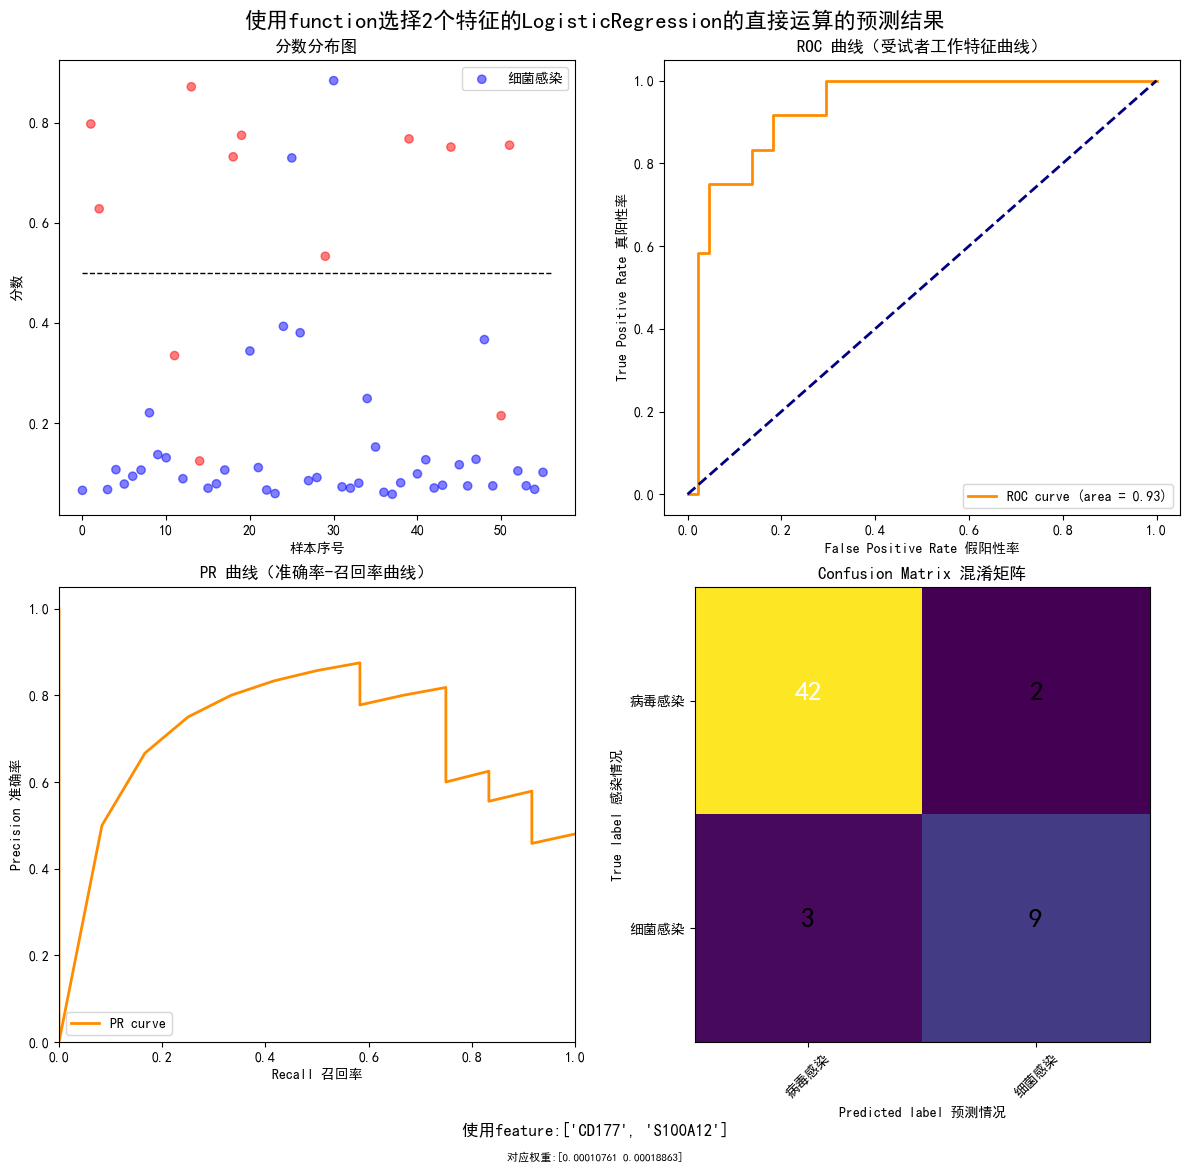

time = 10376.050197669118 acc = 0.9107142857142857
coef = [1. 2.]
intercept = [-2.83133156]
time = 15288.635880587295 acc = 0.9107142857142857
coef = [2. 3.]
intercept = [-2.83133156]
time = 21117.83044448242 acc = 0.9107142857142857
coef = [2. 4.]
intercept = [-2.83133156]
time = 26475.59270567064 acc = 0.9107142857142857
coef = [3. 5.]
intercept = [-2.83133156]
time = 33192.6620473319 acc = 0.9107142857142857
coef = [4. 6.]
intercept = [-2.83133156]
time = 45848.23751389096 acc = 0.9107142857142857
coef = [5. 9.]
intercept = [-2.83133156]
time = 53884.38442608224 acc = 0.9107142857142857
coef = [ 6. 10.]
intercept = [-2.83133156]
time = 63329.08400455114 acc = 0.9107142857142857
coef = [ 7. 12.]
intercept = [-2.83133156]
time = 74429.22330043757 acc = 0.9107142857142857
coef = [ 8. 14.]
intercept = [-2.83133156]
time = 87474.96301554416 acc = 0.9107142857142857
coef = [ 9. 17.]
intercept = [-2.83133156]
time = 102807.32238308647 acc = 0.9107142857142857
coef = [11. 19.]
intercept = [

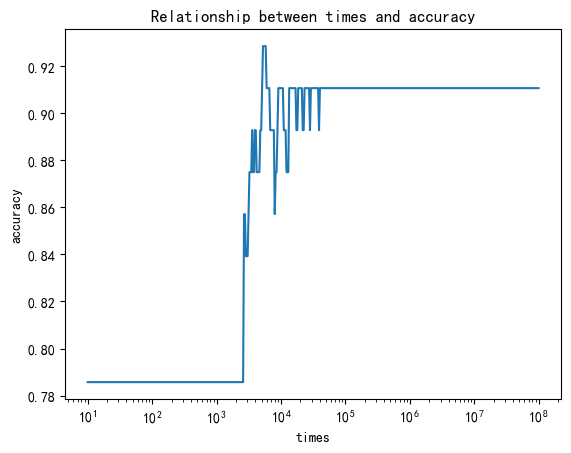

In [150]:
coef, reselect = test_method(
    chi2, 
    LogisticRegression(),
    2, 
    X_train, X_test, y_train, y_test)

# 测试

In [151]:
viral_feature =  ['ISG15', 'MX1', 'CD74']
viral_weight =  [11,  8, 24]
viral_times = 84694.59808314576
viral_intercept = -2.8716859
viral_model = LinearRegression()
bacterial_feature =  ['CD177', 'S100A12']
bacterial_weight = [ 7,12]
bacterial_times = 63329.08400455114
bacterial_model = LinearRegression()
bacterial_intercept = -2.83133156

In [154]:
def cal_score(feature, weight, times, data, model, intercept):
    score = []
    indexs = []
    for i in range(len(feature)):
        id = gpl.table[gpl.table['Gene Symbol'] == feature[i]]['ID'].values[0]
        index = data.columns.get_loc(id)
        indexs.append(index)
    for i in range(len(data)):
        # if model is in LinearRegression, LinearSVC
        if model in [LinearRegression, LinearSVC]:
            score.append(
                np.dot(
                    data.iloc[i, indexs].values,weight
                    )/times
                )
        elif model in [RidgeClassifier(),NuSVC()]:
            score.append(
                np.dot(
                    data.iloc[i, indexs].values,weight
                    )/times + 0.5
                )
        elif model in [LogisticRegression()]:
            z = np.dot(
                data.iloc[i, indexs].values,weight
            )/times  + intercept
            
            score.append(1/(1+np.exp(-z)))
        else:
            z = np.dot(
                data.iloc[i, indexs].values,weight
            )/times  + intercept
            score.append(1 / (1 + np.exp(-z)))

    return score

In [142]:
z = 10000
y_pred = 1 / (1 + np.exp(-z))
y_pred

1.0

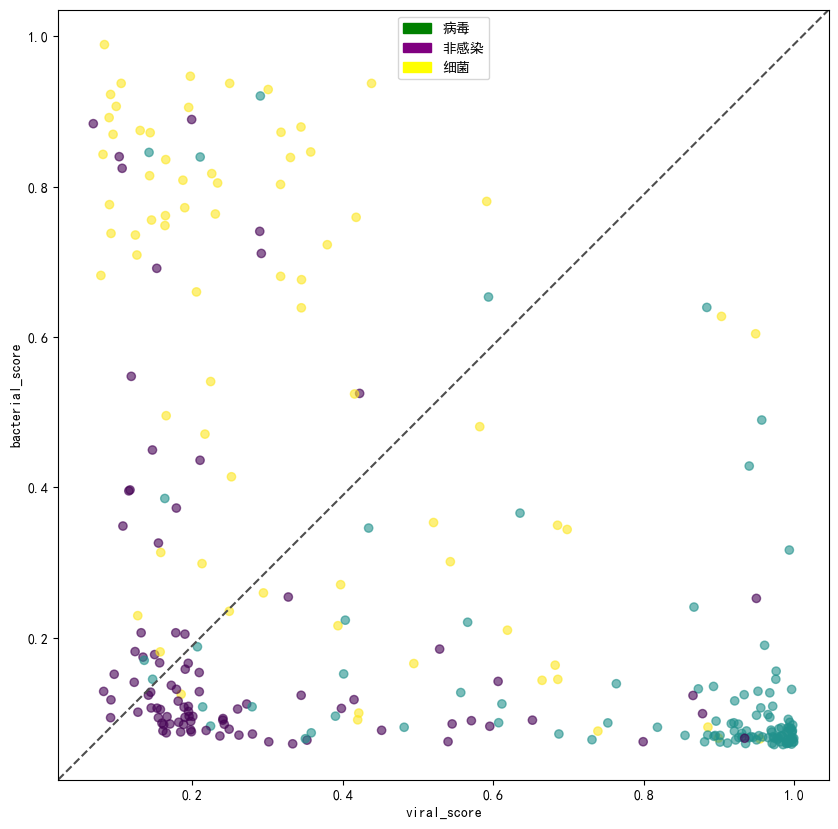

In [163]:
from matplotlib import patches


viral_score = cal_score(viral_feature, viral_weight,viral_times, gse_csv, viral_model, viral_intercept)
bacterial_score = cal_score(bacterial_feature, bacterial_weight,bacterial_times, gse_csv, bacterial_model, bacterial_intercept)
y = gse_csv['infection_status'].map({'viral': 1, 'non-infectious illness': 0, 'bacterial': 2})

fig, ax = plt.subplots( 1,1, figsize=(10,10))
ax.scatter(
    viral_score,
    bacterial_score,
    c=y,
    alpha=0.6
)
ax.set_xlabel('viral_score')
ax.set_ylabel('bacterial_score')

# 比例尺保持一致
ax.set_aspect('equal')

# 表明不同颜色意义
ax.legend(
    handles=[
        patches.Patch(color='green', label='病毒'),
        patches.Patch(color='purple', label='非感染'),
        patches.Patch(color='yellow', label='细菌')
    ]
)

# 画y=x
ax.plot(
    [0, 1], [0, 1],
    transform=ax.transAxes,
    ls="--",
    c=".3"
)